# **PIMA Indians Diabetes Database**
Version 2.0
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DQT4VYxYkkvBYuCRxkaoQ6-sWEwemYbM?usp=sharing)
---

**Context**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

**Content**

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes:
* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

**Acknowledgements**

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

**Inspiration**

Can you build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?

# Machine Learning Pipeline



1. Data Understanding
   
    1.1 Import Libraries

    1.2 Data Exploration

    1.3 Generate Profile Report

2. Data Preparation

    2.1 Exploratory Data Analysis

    2.2 Analyze Value of Zero

    2.3 Remove Outliers

3. Modeling

    3.1 Define Features and Target

    3.2 Compare Baseline Models
      * Random Forest Classifier
      * AdaBoost Classifier
      * Gradient Boosting Classifier
      * XGBoost Classifier

  3.3 Hyperparameter Tuning Using Optuna 

4. Evaluation
    
    4.1 Create Model Using Best Parameter

    4.2 Draw AUC-ROC Curve

# 1. Data Understanding

## 1.1 Import Libraries

In [ ]:
!pip install pandas==0.25
!pip install pandas-profiling==2.8.0
!pip install optuna

In [44]:
# Dataframe
import pandas as pd

# Numeric calculation
import numpy as np
import statistics as st
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Profiling
from pandas_profiling import ProfileReport

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# XGboost
from xgboost import XGBClassifier

# Optuna
import optuna

## 1.2 Data Exploration

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/elvanselvano/ml-projects/main/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [8]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

## 1.3 Generate Profile Report

In [10]:
profile = ProfileReport(df, explorative=True)

In [12]:
profile.to_file("profiling_report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Data Preparation

## 2.1 Exploratory Data Analysis

In [13]:
def analyze(column):
  data = {}
  data['Column'] = column.name
  data['Mean'] = st.mean(column)
  data['Mode'] = Counter(column).most_common()[0][0]
  data['Median'] = st.median(column)
  data['Variance'] = st.variance(column)
  data['Standard Deviation'] = st.stdev(column)
  data['Skew'] = column.skew()
  return pd.DataFrame([data])

def dataframe_analysis():
  result = pd.DataFrame()

  for col in df.columns:
    analysis = analyze(df[col])
    result = result.append(analysis)

  return result.reset_index(drop=True)

def plot_distribution(column):
  f, (ax_box, ax_hist) = plt.subplots(nrows=2, 
                                      sharex=True, 
                                      figsize=(8, 5),
                                      gridspec_kw={"height_ratios": {0.2, 1}})
  
  info = analyze(column)
  mean = info['Mean'].values[0]
  median = info['Median'].values[0]
  mode = info['Mode'].values[0]

  sns.boxplot(x=column, ax=ax_box)
  ax_box.axvline(mean, color='r', linestyle='--')
  ax_box.axvline(median, color='g', linestyle=':')
  ax_box.axvline(mode, color='b', linestyle='-')
  ax_box.set(xlabel='')

  sns.histplot(x=column, ax=ax_hist, kde=True)
  ax_hist.axvline(mean, color='r', linestyle='--')
  ax_hist.axvline(median, color='g', linestyle=':')
  ax_hist.axvline(mode, color='b', linestyle='-')

  plt.legend({'Mean':mean, 'Median':median, 'Mode':mode})
  plt.show()

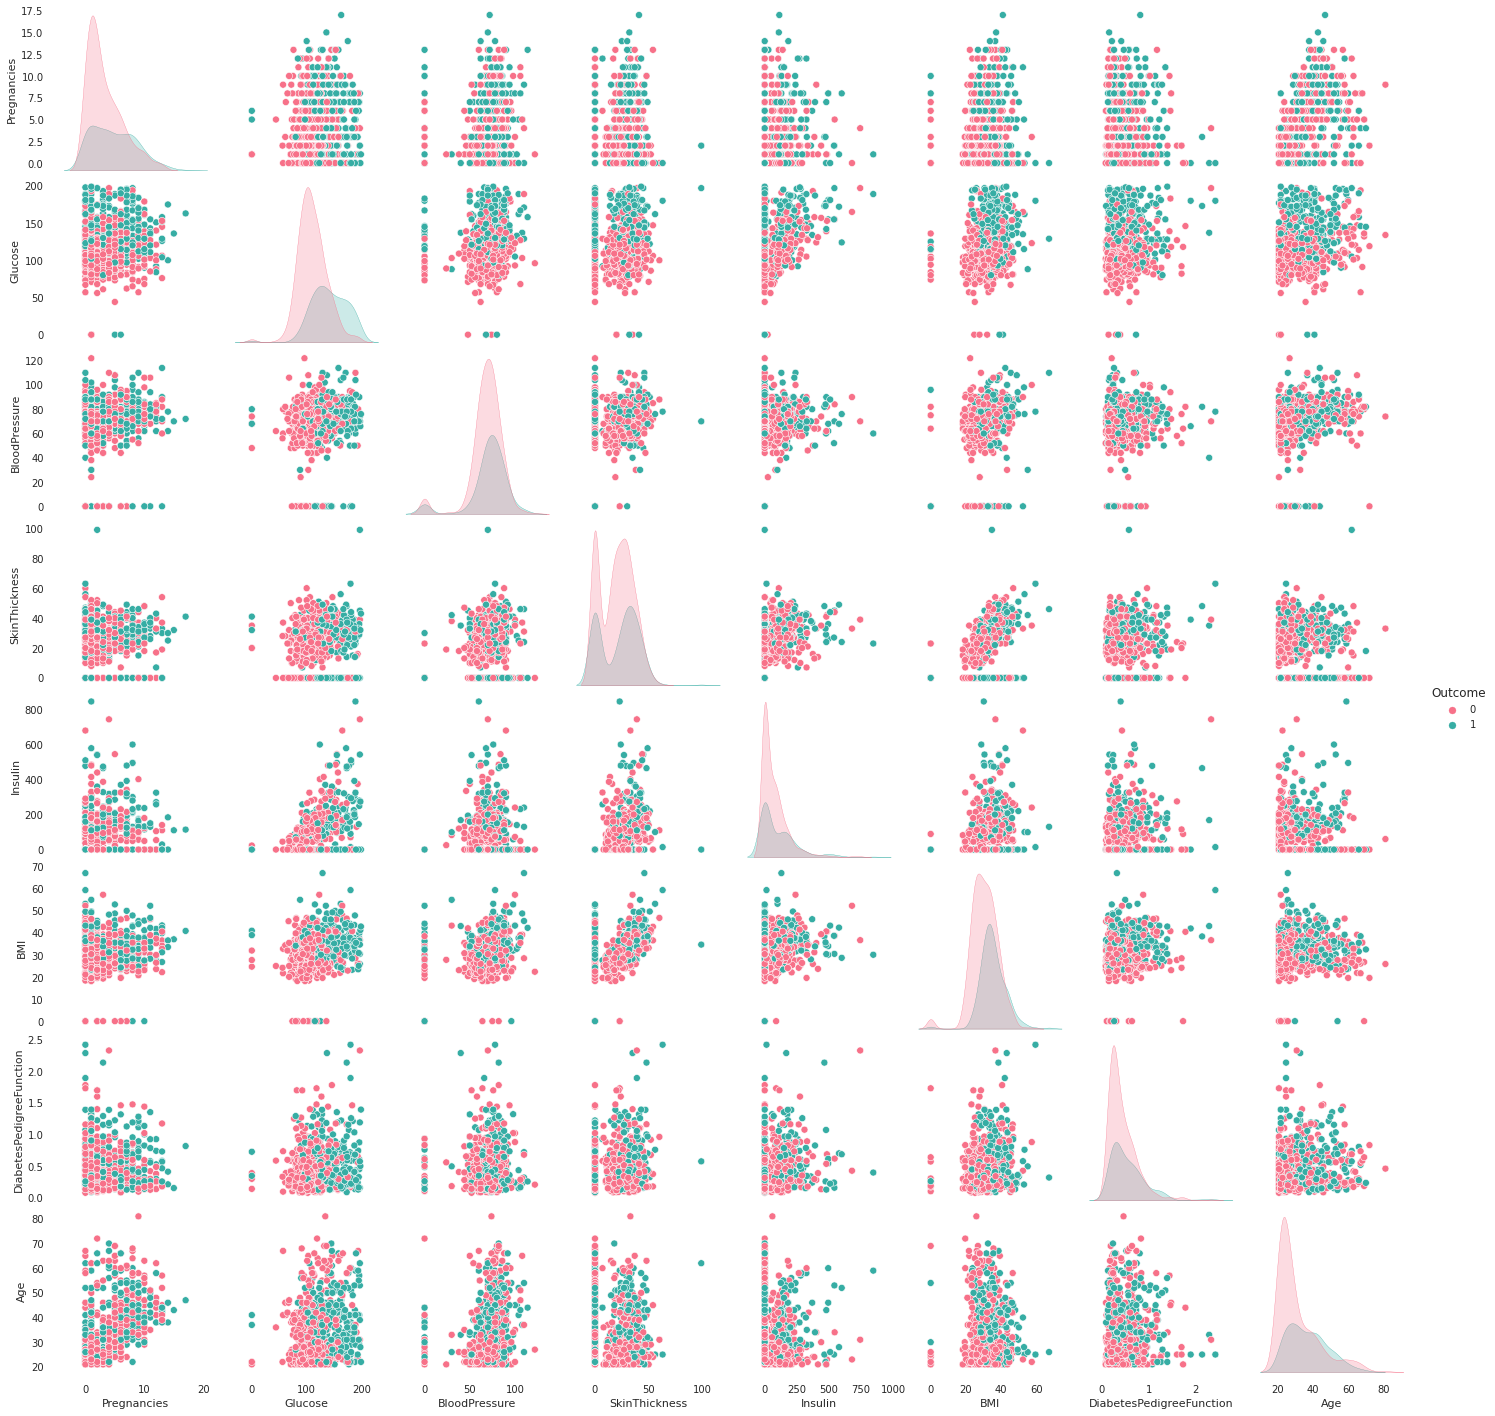

In [14]:
sns.pairplot(df, hue="Outcome", palette="husl")

In [15]:
dataframe_analysis()

,Column,Mean,Mode,Median,Variance,Standard Deviation,Skew
0,Pregnancies,3.845052,1.000,3.0000,11.354056,3.369578,0.901674
1,Glucose,120.894531,100.000,117.0000,1022.248314,31.972618,0.173754
2,BloodPressure,69.105469,70.000,72.0000,374.647271,19.355807,-1.843608
3,SkinThickness,20.536458,0.000,23.0000,254.473245,15.952218,0.109372
4,Insulin,79.799479,0.000,30.5000,13281.180078,115.244002,2.272251
5,BMI,31.992578,32.000,32.0000,62.159984,7.884160,-0.428982
6,DiabetesPedigreeFunction,0.471876,0.254,0.3725,0.109779,0.331329,1.919911
7,Age,33.240885,22.000,29.0000,138.303046,11.760232,1.129597
8,Outcome,0.348958,0.000,0.0000,0.227483,0.476951,0.635017


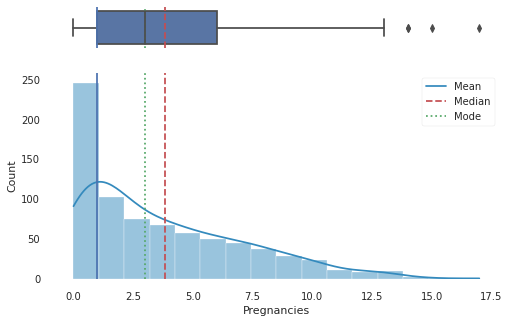

In [16]:
plot_distribution(df['Pregnancies'])

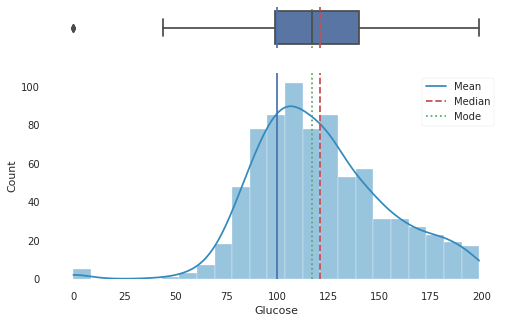

In [17]:
plot_distribution(df['Glucose'])

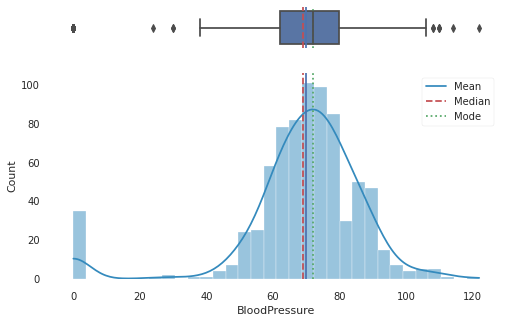

In [18]:
plot_distribution(df['BloodPressure'])

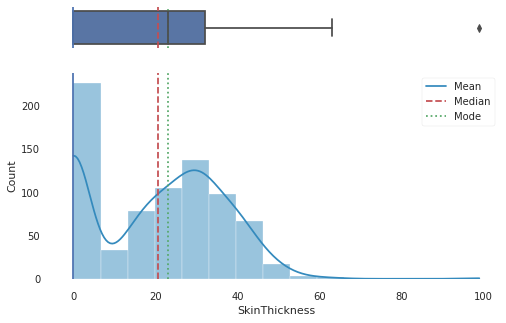

In [19]:
plot_distribution(df['SkinThickness'])

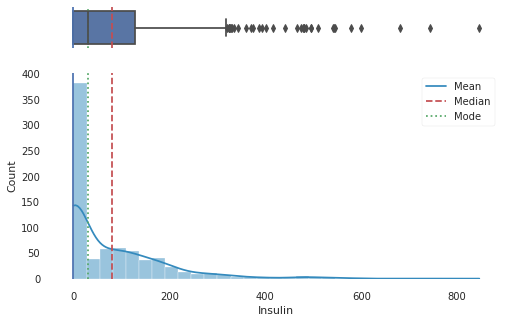

In [20]:
plot_distribution(df['Insulin'])

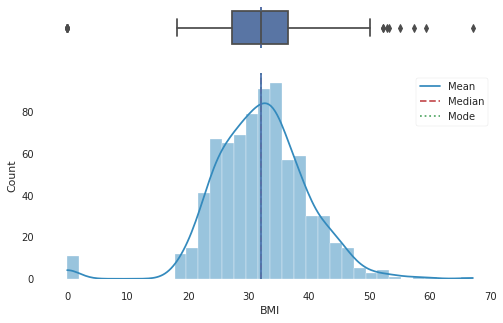

In [21]:
plot_distribution(df['BMI'])

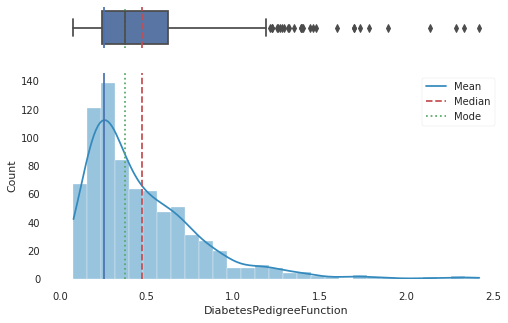

In [22]:
plot_distribution(df['DiabetesPedigreeFunction'])

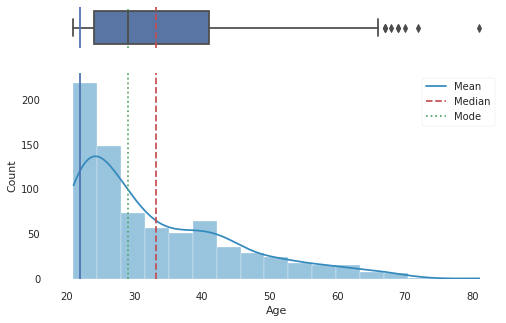

In [23]:
plot_distribution(df['Age'])

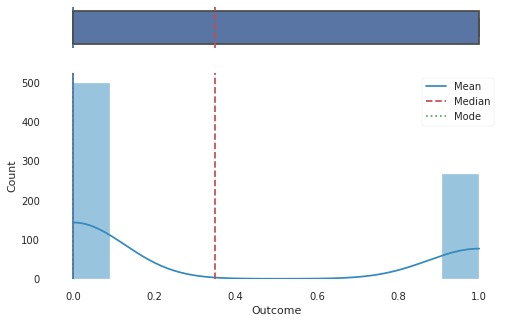

In [24]:
plot_distribution(df['Outcome'])

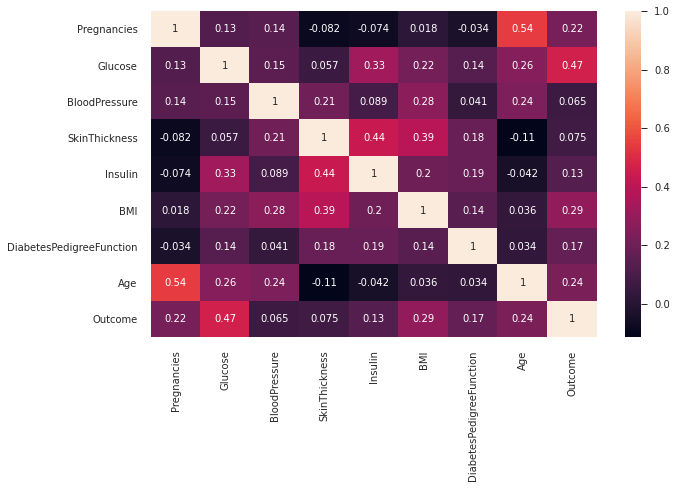

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

## 2.2 Analyze Value of Zero
For some columns, a value of zero doesn't make sense and it indicates that the value is missing.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c9ffd77d0>,
      dtype=object)

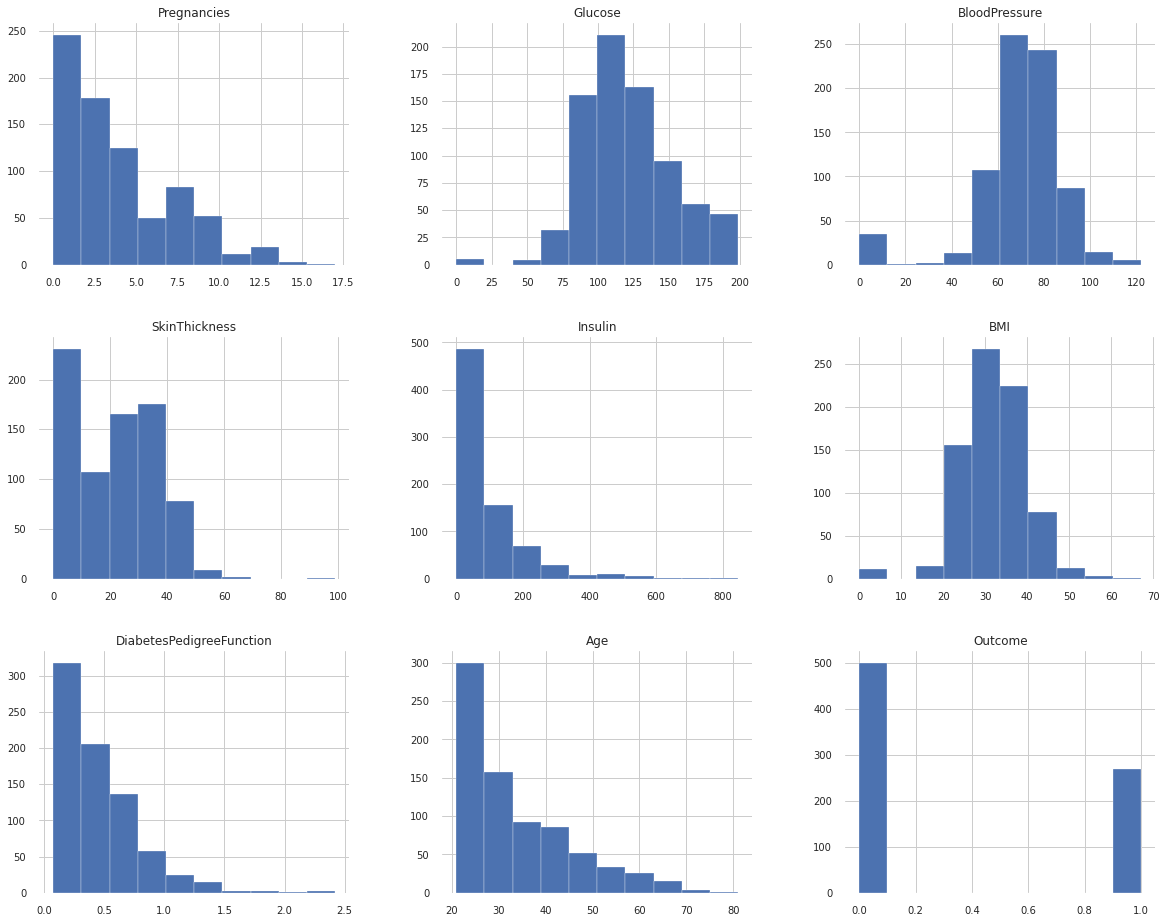

In [26]:
df.hist(figsize=(20, 16))

In [27]:
feats_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[feats_zero] = df[feats_zero].replace(0, np.NaN)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [28]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [31]:
imp = IterativeImputer(max_iter=10, random_state=42)
df_trans = pd.DataFrame(imp.fit_transform(df))
df_trans.columns = df.columns
df_trans.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.000000,35.000000,218.903553,33.600000,0.627,50.0,1.0
1,1.0,85.0,66.000000,29.000000,70.314661,26.600000,0.351,31.0,0.0
2,8.0,183.0,64.000000,21.542781,268.507178,23.300000,0.672,32.0,1.0
3,1.0,89.0,66.000000,23.000000,94.000000,28.100000,0.167,21.0,0.0
4,0.0,137.0,40.000000,35.000000,168.000000,43.100000,2.288,33.0,1.0
5,5.0,116.0,74.000000,22.078010,125.695623,25.600000,0.201,30.0,0.0
6,3.0,78.0,50.000000,32.000000,88.000000,31.000000,0.248,26.0,1.0
7,10.0,115.0,72.971094,31.565415,136.287418,35.300000,0.134,29.0,0.0
8,2.0,197.0,70.000000,45.000000,543.000000,30.500000,0.158,53.0,1.0
9,8.0,125.0,96.000000,34.062564,161.554785,35.832462,0.232,54.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c970c0a90>,
      dtype=object)

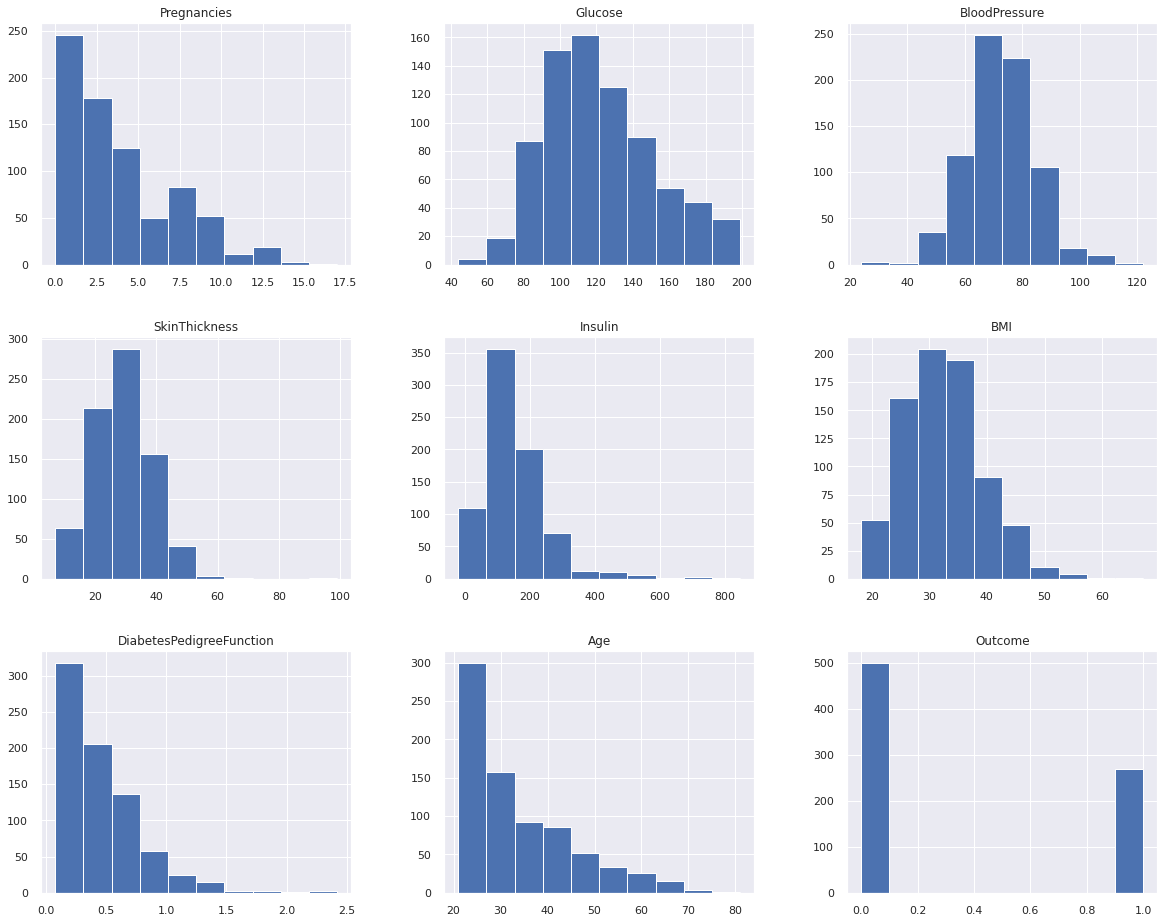

In [32]:
df_trans.hist(figsize=(20, 16))

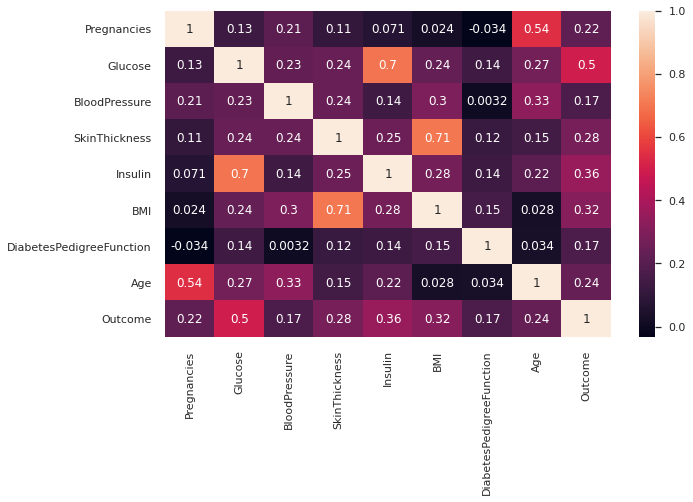

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(df_trans.corr(), annot=True)
plt.show()

## 2.3 Remove Outliers


In [34]:
Q1 = df_trans.quantile(0.25)
Q3 = df_trans.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Pregnancies                   5.000000
Glucose                      42.000000
BloodPressure                16.000000
SkinThickness                12.891166
Insulin                     100.004375
BMI                           9.100000
DiabetesPedigreeFunction      0.382500
Age                          17.000000
Outcome                       1.000000
dtype: float64


In [35]:
df_cleaned = df_trans[~((df_trans < (Q1 - 1.5 * IQR)) |(df_trans > (Q3 + 1.5 * IQR))).any(axis=1)]
df_cleaned.shape

(682, 9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c96c75650>,
      dtype=object)

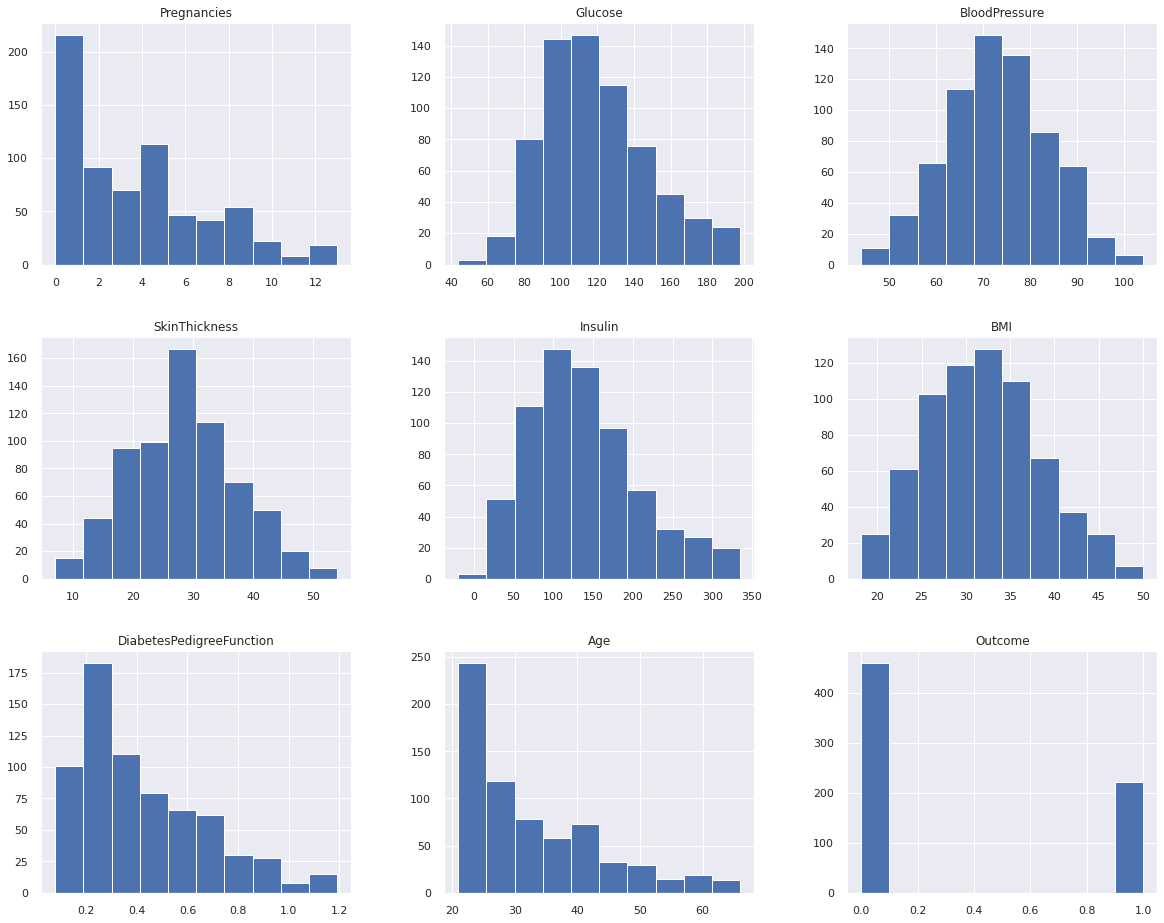

In [36]:
df_cleaned.hist(figsize=(20, 16))

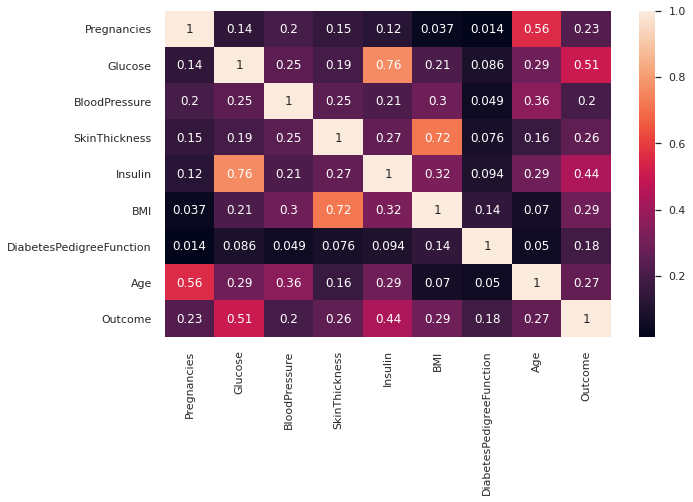

In [37]:
plt.figure(figsize=(10,6))
sns.heatmap(df_cleaned.corr(), annot=True)
plt.show()

# 3. Modeling

## 3.1 Define Features and Target

In [57]:
X = df_cleaned.drop('Outcome', axis=1)
y = df_cleaned['Outcome']

## 3.2 Compare Baseline Models

In [58]:
def model_evaluation(X, y, model, name):
  # Split dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Cross Validation
  scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1')
  
  # Predict on test set
  model.fit(X_train, y_train)
  preds = model.predict(X_test)

  # Generate classification report
  target_names = ['0', '1']
  print(classification_report(y_test, preds, target_names=target_names))
  print(name + ": " + str(scores.mean()))

In [59]:
rf = RandomForestClassifier(n_jobs = -1, max_features='sqrt', random_state=42)
dt = DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 5, max_depth = 1, random_state=42)
ada = AdaBoostClassifier(base_estimator=dt, n_estimators = 1000, learning_rate = 0.05, algorithm = 'SAMME', random_state=42)
grd = GradientBoostingClassifier(learning_rate = 0.01, subsample = 0.5, n_estimators = 100, random_state=42)
xgb = XGBClassifier(learning_rate = 0.01, n_estimators = 1000, max_depth = 4, n_jobs = -1, random_state=42)

### 3.2.1 Random Forest Classifier

In [60]:
model_evaluation(X, y, rf, 'RandomForestClassifier')

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        93
           1       0.68      0.61      0.64        44

    accuracy                           0.78       137
   macro avg       0.75      0.74      0.74       137
weighted avg       0.78      0.78      0.78       137

RandomForestClassifier: 0.6101635081072285


### 3.2.2 AdaBoost Classifier

In [53]:
model_evaluation(X, y, ada, 'AdaBoostClassifier')

              precision    recall  f1-score   support

           0       0.82      0.91      0.86        93
           1       0.76      0.57      0.65        44

    accuracy                           0.80       137
   macro avg       0.79      0.74      0.76       137
weighted avg       0.80      0.80      0.79       137

AdaBoostClassifier: 0.5934490262549218


### 3.2.3 Gradient Boosting Classifier

In [54]:
model_evaluation(X, y, grd, 'GradientBoostingClassifier')

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        93
           1       0.75      0.48      0.58        44

    accuracy                           0.78       137
   macro avg       0.77      0.70      0.72       137
weighted avg       0.78      0.78      0.77       137

GradientBoostingClassifier: 0.5262120472120472


### 3.2.4 XGBoost Classifier

In [61]:
model_evaluation(X, y, xgb, 'XGBClassifier')

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        93
           1       0.66      0.61      0.64        44

    accuracy                           0.77       137
   macro avg       0.74      0.73      0.74       137
weighted avg       0.77      0.77      0.77       137

XGBClassifier: 0.6017378258554728


## 3.3 Hyperparamater Tuning Using Optuna

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [103]:
print('Training Data: ', X_train.shape)
print('Testing Data: ', X_test.shape)
print('Training Target: ', y_train.shape)
print('Testing Target: ', y_test.shape)

Training Data:  (545, 8)
Testing Data:  (137, 8)
Training Target:  (545,)
Testing Target:  (137,)


In [104]:
def objective(trial, data=X_train, target=y_train):
  X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
  
  param = {
      'tree_method':'gpu_hist',  # use gpu
      'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
      'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
      'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
      'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
      'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
      'n_estimators': 4000,
      'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
      'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
      'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
  }
  model = XGBClassifier(**param)  
  
  model.fit(X_training, y_training, eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=100, verbose=False)
  
  preds = model.predict(X_valid)
  return f1_score(y_valid, preds)

In [105]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2021-04-17 17:36:37,734] A new study created in memory with name: no-name-940a6de4-4ab7-4643-b86e-298e52c0faad
[I 2021-04-17 17:36:38,036] Trial 0 finished with value: 0.0 and parameters: {'lambda': 0.25231307159361693, 'alpha': 3.225406995126181, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.018, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 177}. Best is trial 0 with value: 0.0.
[I 2021-04-17 17:36:38,324] Trial 1 finished with value: 0.0 and parameters: {'lambda': 0.23243635268044582, 'alpha': 0.08842322835400279, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.01, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 153}. Best is trial 0 with value: 0.0.
[I 2021-04-17 17:36:39,451] Trial 2 finished with value: 0.0 and parameters: {'lambda': 0.007219771142550803, 'alpha': 0.1225180171747908, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.01, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 264}. Best is trial 0

In [106]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,0.000000,2021-04-17 17:36:37.740717,2021-04-17 17:36:38.036301,0 days 00:00:00.295584,3.225407,0.4,0.252313,0.018,5,177,48,0.8,COMPLETE
1,1,0.000000,2021-04-17 17:36:38.037993,2021-04-17 17:36:38.323859,0 days 00:00:00.285866,0.088423,0.4,0.232436,0.010,9,153,2020,0.6,COMPLETE
2,2,0.000000,2021-04-17 17:36:38.325495,2021-04-17 17:36:39.450895,0 days 00:00:01.125400,0.122518,0.7,0.007220,0.010,20,264,2020,0.5,COMPLETE
3,3,0.000000,2021-04-17 17:36:39.452747,2021-04-17 17:36:39.734879,0 days 00:00:00.282132,0.010595,0.6,0.770352,0.016,7,57,2020,0.5,COMPLETE
4,4,0.000000,2021-04-17 17:36:39.738818,2021-04-17 17:36:40.018037,0 days 00:00:00.279219,2.744003,1.0,0.134500,0.018,7,118,2020,1.0,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0.000000,2021-04-17 17:38:34.885138,2021-04-17 17:38:35.184308,0 days 00:00:00.299170,3.492917,1.0,2.349273,0.016,9,140,48,0.8,COMPLETE
196,196,0.657895,2021-04-17 17:38:35.185941,2021-04-17 17:38:35.981787,0 days 00:00:00.795846,2.511473,1.0,1.839047,0.016,9,7,48,0.8,COMPLETE
197,197,0.701299,2021-04-17 17:38:35.983593,2021-04-17 17:38:36.766766,0 days 00:00:00.783173,6.349891,1.0,1.347380,0.016,9,12,48,0.8,COMPLETE
198,198,0.727273,2021-04-17 17:38:36.768589,2021-04-17 17:38:37.302406,0 days 00:00:00.533817,3.642760,1.0,0.892008,0.016,9,1,48,0.8,COMPLETE


In [107]:
optuna.visualization.plot_optimization_history(study)

In [108]:
optuna.visualization.plot_parallel_coordinate(study)

In [109]:
optuna.visualization.plot_slice(study)

In [110]:
optuna.visualization.plot_param_importances(study)

# 4. Evaluation

## 4.1 Create Model with Best Parameter

In [112]:
best_trial = study.best_trial.params
best_trial

{'alpha': 1.1279847358015627,
 'colsample_bytree': 0.9,
 'lambda': 0.3942414973245321,
 'learning_rate': 0.01,
 'max_depth': 13,
 'min_child_weight': 8,
 'random_state': 48,
 'subsample': 0.5}

In [113]:
xgb_tuned = XGBClassifier(**best_trial)
xgb_tuned.fit(X_train, y_train)
preds = xgb_tuned.predict(X_test)
target_names = ['0', '1']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        93
           1       0.74      0.59      0.66        44

    accuracy                           0.80       137
   macro avg       0.78      0.75      0.76       137
weighted avg       0.80      0.80      0.80       137



## 4.2 Draw AUC-ROC Curve

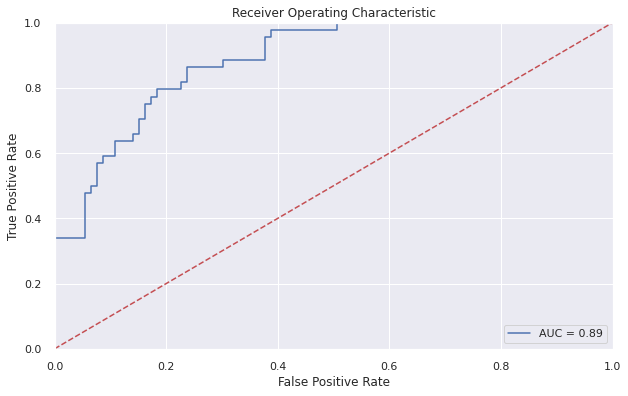

In [114]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_tuned.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()